In [44]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import numpy as np
from shapely.geometry import Polygon

import rawpy
import tqdm

In [17]:
path = "/Users/dsuo/Downloads/2021-01-19-0001.dng"
with rawpy.imread(path) as raw:
    rgb = raw.postprocess()

In [19]:
rgb.shape

(17600, 13600, 3)

In [177]:
DPI = 1600

film_format = {
    "35": {
        "width": 36.,
        "height": 24.
    },
    "6x4.5": {
        "width": 56.,
        "height": 42.
    },
    "6x6": {
        "width": 56.,
        "height": 56.
    },
    "6x7": {
        "width": 56.,
        "height": 67.
    }
}

In [178]:
def poly_area(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def pixel_area(width, height, dpi):
    return width / 25.4 * dpi * height / 25.4 * dpi

def film_area(fmt, dpi):
    fmt = film_format[fmt]
    return pixel_area(fmt["width"], fmt["height"], dpi)

In [187]:
target_area = film_area("35", DPI)

In [ ]:
plt.figure(figsize=(16, 12))
plt.imshow(rgb)

In [169]:
bw = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

In [170]:
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

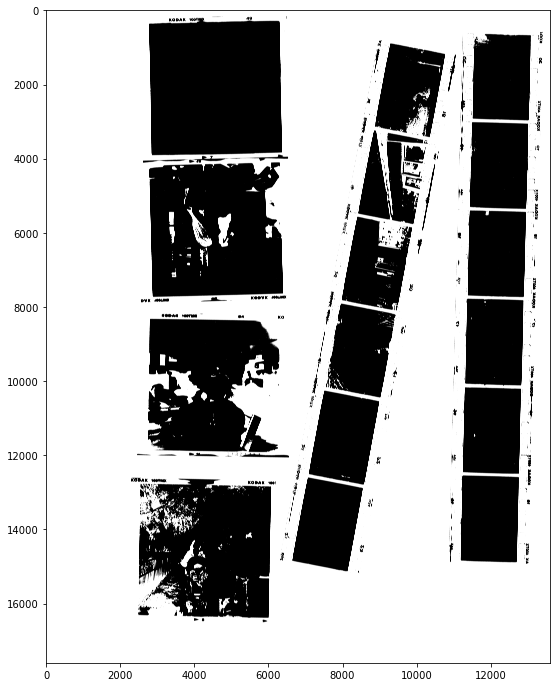

In [163]:
ret, thresh = cv2.threshold(bw, 115, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(16, 12))
plt.imshow(thresh, cmap="gray")

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(thresh, cmap="gray")

polys = []
paths = []

area_threshold = 0.1
found = 0

for threshold in np.linspace(200, 100, 11):
    ret, im = cv2.threshold(bw, threshold, 255, cv2.THRESH_BINARY)
    cnts = cv2.findContours(im.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
    
    
    for c in tqdm.tqdm(cnts):
        idxs = cv2.convexHull(c, returnPoints = False)
        hull = c[idxs.squeeze()]
        peri = cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, 0.015 * peri, True)

        if len(approx) == 4:
            verts = approx.squeeze()
            area = poly_area(verts[:,0], verts[:, 1])

            if area < target_area * (1 - area_threshold) or area > target_area * (1 + area_threshold):
                continue

            currPoly = Polygon(verts)
            exists = False
            for poly in polys:
                if poly.intersects(currPoly):
                    exists = True
                    print("overlap!")
                    break

            if exists:
                continue

            print(area)
            polys.append(currPoly)

            verts = np.concatenate((verts, [verts[0]]))
            path = Path(verts, codes)
            patch = patches.PathPatch(path)
            ax.add_patch(patch)
            
            paths.append(path)

            found += 1
            
print(found)